<a id='top'></a>

# London Crime - Big Data Analytics | a.y. 2018/19
#### Amendola M. Cornacchia G. Salinas M.
<hr>

*All the additional data that has been used can be found in the ``data`` folder provided with this notebook*

## Table of Contents
1. [Dataset Description](#dataset) 
2. [Data Cleaning](#cleaning) 
    1. [Missing Values](#mv)
    2. [Record Filtering](#rf)
3. [Exploratory Analysis](#ea)
    1. [Features Distributions](#fd)
    2. [Geolocalized Features Distribution](#geo)
    3. [Correlations](#cc)
        1. [Dataset Reshaping](#dr)
4. [Analytical Project Proposals](#app)

In [10]:
%matplotlib inline
import numpy as np
import pandas as pd 
import scipy as sp
from scipy.interpolate import spline
import sklearn as sk # data mining tools
import matplotlib.pylab as plt # plotting
import seaborn as sns # advanced plotting
from pandas.tools.plotting import scatter_matrix
from __future__ import division
from matplotlib import rc
from matplotlib import ticker
import matplotlib as mpl
import matplotlib.colors as colors
import warnings
import geopandas
#from geopy.geocoders import Nominatim
import requests
from collections import defaultdict
warnings.filterwarnings("ignore")

def get_ind(arr,x):
    return list(arr).index(x)

def explore_ds(df):
    print("|Dataset| = "+str(len(df)))
    df.info()
    print("--------------")
    for c in df.columns:
        print(str(c)+" has "+str(len(df[c].unique()))+" different values")
        
#Function that plots an aray of lines on the same figure
def draw_linechart(w,h,v_lines, title, x_label, y_label, rot, legend, sort, sort_array, grid, sci,save, xticks_, ylim=[]):
    
    fig = plt.figure(figsize=(w,h))
    
    #title and axis labels
    plt.title(title,fontsize=20)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    
    if(len(ylim)>0):
        axes = plt.gca()
        axes.set_ylim(ylim)
    
    #scientific notation
    if sci:
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    
    #ticks angle (0=horizontal, 90=vertical)
    plt.xticks(xticks_, rotation=rot)
    
    #grid
    if grid:
        plt.grid(color='grey', linestyle='--', linewidth=0.5)
    
    
    for i in range(0, len(v_lines)):
        
            DS = v_lines[i]['dataset']
                                   
            x = v_lines[i]['x_att']
            y = v_lines[i]['y_att']
            
            if sort:
                DS["sort"] = DS_gb.apply(lambda row: get_ind(sort_array, row["borough"]),axis=1)
                DX = DS.sort_values("sort", ascending=True)
                

            xnew = np.linspace(DS[x].min(),DS[x].max(),300) #300 represents number of points to make between T.min and T.max
 
            ynew = sp.interpolate.spline(DS[x],DS[y],xnew)
       
            #plotting the line
            plt.plot(xnew, ynew, linewidth=v_lines[i]['linewidth'], color=v_lines[i]['colore'], label=v_lines[i]['label'], marker=v_lines[i]['marker'], linestyle=v_lines[i]['linestyle'])# avg=DS.groupby('month', as_index=False).value.sum()
            
    #legend
    if legend:
         plt.legend(bbox_to_anchor=(1,0.7), loc="center left")
            
    if save:
        plt.savefig(title+".png", bbox_inches="tight")
                
        
def filter_and_plot(DS, filters, attribute, title, x_att, y_att, x_lab, y_lab, colors, xticks_, ylim=[], lines_2_plot=[]):
    
    for i in range(0, len(filters)):
                        D = DS[DS[attribute]==filters[i]]
                        elem = {'dataset':D, 'x_att':x_att, 'y_att':y_att, 'label':filters[i], 'linewidth': 1.25, 'colore':colors[i], "linestyle":"-", "marker":" "}
                        lines_2_plot.append(elem)
    
    draw_linechart(12,6, lines_2_plot, title, x_lab, y_lab, 0, True, False, 1, True, True, True, xticks_, ylim)

    #Function that plots a barchart
def barChart(df, title_, xlabel_, ylabel_, legend, legend_title, xticks_, save):
    ax=df.plot(kind='bar', figsize=(10,6), width=0.9, fontsize=14 )
    ax.set_title(title_, {'fontsize':20})
    ax.set_xlabel(xlabel_, { 'size'   : 17})
    ax.set_ylabel(ylabel_,  {'size'   : 17})
    if(len(xticks_)>0):
        x_pos = [i for i, _ in enumerate(xticks_)]
        plt.xticks(x_pos, xticks_, rotation=0)
    
    if legend:
        leg=ax.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.7))
        leg.set_title(title=legend_title,  prop = {'size':'x-large'})
    else:
        leg=ax.legend()
        leg.set_visible(False)
    plt.grid(color='grey', linestyle='--', linewidth=0.5)
    if save : 
        plt.savefig(title_+'.pdf', dpi=1000, bbox_inches = "tight", pad_inches = 1)

def make_donut(sizes, colors, text, expl, labels, r, f_sz, save = False):
    col = [[i/255. for i in c] for c in colors]
    fig, ax = plt.subplots()
    ax.axis('equal')
    width = 0.55
    kwargs = dict(colors=col, startangle=180)
    
    outside, _ = ax.pie(sizes, radius=r, explode = expl, shadow = True, pctdistance=1-width/2,labels=labels,**kwargs)
    plt.setp( outside, width=width, edgecolor='white')

    
    #if len(text) > 0:
        #kwargs = dict(size=f_sz, fontweight='bold', va='center')
        #ax.text(0, 0, text, ha='center', **kwargs)

    if save : 
        plt.savefig(text+'.pdf', dpi=1000, bbox_inches="tight")
    
    plt.show()        
           
#Geo distrib
df_lsoa = geopandas.read_file('data/geo/LSOA_2011_London_gen_MHW.shp').rename(columns = {'LSOA11CD': 'lsoa_code'})
#Split dataset into years in order to allow temporal analysis
def get_lsoasplit_by_year(df, no_crime=False):
    if no_crime:
        ds_year =  [df[df['year'] == i ].groupby(['lsoa_code'], as_index=False).agg({
            'value':np.sum,
            'borough':'first',
            'lat':'first',
            'long':'first'
            }) for i in range(2008, 2017)]
    else:
        ds_year = [df[df['year'] == i ].groupby(['lsoa_code', 'major_category'], as_index=False).agg({
            'value':np.sum,
            'borough':'first',
            'lat':'first',
            'long':'first'
        }) for i in range(2008, 2017)]
    for i in range(0, len(ds_year)):
        ds_year[i] = pd.merge(ds_year[i], df_lsoa, on=['lsoa_code'], validate='many_to_one').drop([
            'LSOA11NM','MSOA11CD','MSOA11NM',
             'LAD11CD', 'LAD11NM', 'RGN11CD',
             'RGN11NM','USUALRES','HHOLDRES',
             'COMESTRES','POPDEN','HHOLDS',
             'AVHHOLDSZ'
        ], axis=1)
        #ds_year[i]['crime/day'] = ds_year[i]['value'] / 365
        ds_year[i]['crime/month'] = ds_year[i]['value'] / 12
    #print(ds_year[0].columns)
    return ds_year    

#Array of colormap steps based on values disributions and visualization
bounds = dict({
    'all' : [0, 1.5, 3, 5, 10, 20, 40, 100, 200, 300],
    'Burglary' : [0, 1.2, 2.5, 4.2, 5, 10, 15, 20],
    'Criminal Damage' : [0, 0.3, 1, 2.5, 4, 5, 10, 15, 20],
    'Robbery': [0, 0.3, 0.6, 1, 1.5, 2, 2.5, 3.5, 5, 10, 15, 20],
    'Drugs': [0, 0.3, 0.6, 1, 1.5, 2, 2.5, 3.5, 5, 10, 15, 20, 30, 50, 70],
    'Violence Against the Person': [0, 1, 3, 5, 7, 10, 15, 20, 30, 50, 80],
    'Theft and Handling': np.array([0,0.5, 0.8, 3, 5, 10, 15, 30, 40, 50, 75, 100, 200])
})

#This function merges efficiently the base dataset with the geo-loc one
def get_geo_ds(df):
    lc_lookup = pd.read_csv("data/london-lookup1.csv").rename(columns = {'lsoa11': 'lsoa_code'})
    lc_lookup = lc_lookup.groupby(['lsoa_code']).aggregate(np.mean)
    #Geolocalized DataSet
    return pd.merge(df, lc_lookup, on=['lsoa_code'], validate='many_to_one')
#This function merges efficiently the base dataset with the enriched one
def get_densitypp_eco_ds(df):
    lc_density = pd.read_csv("data/demographics.csv")
    lc_density = lc_density.groupby(['lsoa_code']).aggregate('first')
    lc_eco = pd.read_csv("data/economics.csv")
    lc_eco = lc_eco.groupby(['lsoa_code']).aggregate('first')
    lc_area = pd.read_csv("data/area.csv")
    lc_area = lc_area.groupby(['lsoa_code']).aggregate('first')
    #Enriched DataSet
    return pd.merge(df, (pd.merge(lc_density, lc_eco, on=['lsoa_code'], validate='one_to_one')), on=['lsoa_code'], validate='many_to_one')
    
#Plots a Chorophlet map given the major_category and the measure to plot (col) 
def print_chorophlet_years(ds_year, col, crime, bounds, level, save = False, typo='jpg', size=(10,6)):
    colors = [(1, 1, 1), (1, 0.98, 0.9), (1, 0.4, 0)]
    blue_red1 = mpl.colors.LinearSegmentedColormap.from_list('BlueRed1', colors)
    
    cmap = blue_red1#mpl.cm.BuPu
    norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    for i in range(0, len(ds_year)):
        fig, ax = plt.subplots(figsize=size)
        if(crime == "all"):
            df = geopandas.GeoDataFrame(ds_year[i])
        else: 
            df = geopandas.GeoDataFrame(ds_year[i][ds_year[i]['major_category'] == crime])
        df.plot(ax = ax, column = 'crime/month', cmap=cmap, norm = norm)
        #cax = fig.add_axes([0.37, 0.9, 0.6, 0.05])
        df_borough.plot(ax = ax, facecolor = 'none', edgecolor='black')
        
        #Borough annotation
        for idx, row in df_borough.iterrows():
            bor = row['borough']
            m = df[df['borough'] == bor]['crime/month'].max()
            if(m > bounds[len(bounds)-3]):
                plt.annotate(s=row['borough'], xy=row.geometry.centroid.coords[0],
                             fontsize=16, color="black",
                             horizontalalignment='center')
            elif(m > bounds[len(bounds)-4]):
                plt.annotate(s=row['borough'], xy=row.geometry.centroid.coords[0],
                             fontsize=12, color="gray",
                             horizontalalignment='center')
        if(crime == "all"):
            title = "Crimes/month in London, "+str(i+2008)
        else:
            title = crime+" crimes/month in "+str(i+2008)
        ax.set_title(title)
        plt.xticks([])
        plt.yticks([])
        cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        # fake up the array of the scalar mappable. Urgh...
        sm._A = []
        fig.colorbar(sm, cax=cax)
        #fig.tight_layout()
        if save: 
            plt.savefig(crime+str(i+2008)+'_'+level+'_cm.'+typo)
            
#Correlation

def f(x,df_gb):
    
    d = df_gb[df_gb["lsoa_code"]== x["lsoa_code"]]
    if len(d)>0:
         ret = d[att+"s"].iloc[0]
    else:
        ret = 0
    return ret

def give_postal_code(x):
    
    
    s = str(x["lat"])+","+str(x["long"])
    
    geolocator = Nominatim(user_agent="geopy/1.17.0")

    location = geolocator.reverse(s,timeout=100)
     
    if  "postcode" in location.raw["address"].keys():
           ret = location.raw["address"]["postcode"].replace(" ","")
    else:
           ret = "not found"
    return ret
    
    
def pc_to_lsoa(x):
        
    s = str(x["postal_code"])
    
    d = lc_lookup[lc_lookup["pcd"]==s]
    
    if(len(d)>0):
           ret = d["lsoa_code"].iloc[0]
    
    else:
            ret = "not found"
        
    return ret    

def lsoa_to_borough(x):
    
    s = str(x["lsoa_code"])
    
    d = dg_zero[dg_zero["lsoa_code"]==s]
    
    if(len(d)>0):
           ret = d["borough"].iloc[0]
    else:
           ret = "not found"
    return ret
            
#This function merges efficiently the base dataset with the enriched one
def get_corr_ds(df):
    lc_demo = pd.read_csv("data/corr/demographics.csv")
    lc_demo = lc_demo.groupby(['lsoa_code']).aggregate('first')
    
    lc_demo = lc_demo.drop(["total population"],axis=1)
    
    lc_demo1 = pd.read_csv("data/corr/demograph1.csv")
    lc_demo1 = lc_demo1.groupby(['lsoa_code']).aggregate('first')
    
    lc_eco1 = pd.read_csv("data/corr/eco1.csv")
    lc_eco1 = lc_eco1.groupby(['lsoa_code']).aggregate('first')
    
    #Enriched DataSet
    demo = pd.merge(lc_demo1, lc_demo, validate='one_to_one', on='lsoa_code')
    df1 = pd.merge(demo, lc_eco1, on=['lsoa_code'], validate='one_to_one')
    #print (df1.columns)
    df2 = pd.merge(df, df1, on=['lsoa_code'], validate='many_to_one')
    return df2

#df must be grouped on lsoa, major_category
def reshape_crimes(df):
    # seleziono lsoa
    data = []
    crime_lookup = df.major_category.unique()
    crime_vals = [0] * len(crime_lookup)
    old_cols = []
    crime_cols = [c+"_value" for c in crime_lookup]
    i = 1
    df_lsoa = [ df[df['lsoa_code'] == lsoa] for lsoa in df.lsoa_code.unique()]
    for dft in df_lsoa:
        dft = dft.groupby(['lsoa_code', 'major_category'], as_index=False).agg({
        'value':np.sum,
        #'area':'first',
        'borough':'first',
        #'lat':'first',
        #'long':'first',
        #'total population': np.mean,
        #'employed': np.mean,
        #'unemployed' : np.mean
        })
        old_cols = dft.drop('major_category', axis = 1).columns
        old_vals = np.append([dft.values[0][0]], dft.values[0][2:])
        #print(old_vals)
        #new_vals = [dft.values[:][i][5] for i in range(0, len(new_cols))]
        new_value = 0
        for row in dft.values:
            #print(row)
            new_value += row[3]
            crime_vals[get_ind(crime_lookup, row[1])] = row[3]
        #crime_vals[:] = [x / new_value for x in crime_vals]
        old_vals[2] = new_value
        new_vals = np.append(old_vals, crime_vals)
        data.append(new_vals)
        if(i % 1000 == 0): 
            print(str(i)+" lsoa computed")
        i+=1
        #print(dft.values[0])
    new_cols = np.append(old_cols, crime_cols)
    return pd.DataFrame(columns=new_cols, data=data)

def corr_by_year(vect,att1,att2):
    
    for i in range (0,len(vect)):
        v_corr = vect[i].drop(["year"],axis=1).corr()[att1][att2]
        print str(2008+i)+" "+att1+" "+att2+"   "+str(v_corr)

def corr_by_year_ext(vect,values,pois,ths):

    for i in range (0,len(ds_gb)):
        for v in range (0,len(values)):
            for p in range (0,len(pois)):
                v_corr = vect[i].drop(["year"],axis=1).corr()[pois[p]][values[v]]

                if v_corr>= ths:
                    print str(2008+i)+" "+str(values[v])+" "+str(pois[p])+"   "+ str(v_corr)
                if v_corr<= -ths:
                    print str(2008+i)+" "+str(values[v])+" "+str(pois[p])+"   "+ str(v_corr)
                
def heatmap_years(reshaped_years, ann, save, title= "", size = (14, 12)):
    for i in range(0,len(reshaped_years)):

        corr = reshaped_years[i].corr()

        plt.subplots(figsize =size)

        ax = plt.axes()
        hm = sns.heatmap(corr, ax = ax,
                xticklabels=corr.columns.values, annot=ann,
                yticklabels=corr.columns.values, cmap="coolwarm", vmax=1, vmin=-1)

        if(len(title)>0):
            ax.set_title(title)
        else:
            ax.set_title(str(2008+i))
        if save:
            plt.savefig("grafici_corr/HEATMAP"+str(2008+i)+".png", bbox_inches="tight")


            
def insert_pois(at, gb_attr, df_poi, to_drop, reshaped_years ):

        for att in at:
            ps_poi = df_poi[df_poi["subCategory"]==att]

            #(LONG, LAT) ---> POSTAL_CODE

            ps_poi["postal_code"]=ps_poi.apply(lambda row: give_postal_code(row),axis=1)
            ps_poi.head()

            print "step 1/4"

            #(POSTAL_CODE) ---> LSOA_CODE

            ps_poi["lsoa_code"]=ps_poi.apply(lambda row: pc_to_lsoa(row),axis=1)

            print "step 2/4"

            #LSOA_CODE --->BOROUGH

            ps_poi["borough"]=ps_poi.apply(lambda row: lsoa_to_borough(row),axis=1)

            print "step 3/4"

            #Deleting missing values

            poi_def = ps_poi[ps_poi["postal_code"]!="not found"]
            poi_def = poi_def[poi_def["lsoa_code"]!="not found"]

            #Grouping by
            df_gb = poi_def.groupby(gb_attr,as_index=False).count()
            df_gb = df_gb.drop(to_drop,axis=1)
            df_gb = df_gb.rename(columns={"long":att+"s"})

            #Including in the dataset (create new attr ecc)

            print "step 4/4"

            for i in range (0,len(reshaped_years)):
                reshaped_years[i][att+"s"] = reshaped_years[i].apply(lambda row: f(row),axis=1)
                print i

            print "Attribute "+att+" computed"         
            
def plot_corr_by_year(vect,att1,att2,title, save = False, size = (10, 8)):
    vy = []
    vx = np.arange(2008, 2017)
    for i in range (0,len(vect)):
        v_corr = vect[i].corr()[att1][att2]
        vy.append(float(v_corr))

    
    fig = plt.figure(figsize=size)
    axes = plt.gca()
    axes.set_ylim([0, 1])
    #title and axis labels
    plt.title(title,fontsize=20)
    plt.ylabel("Correlation")
    plt.xlabel("years")

    #ticks angle (0=horizontal, 90=vertical)
    plt.xticks(vx, rotation=0)

    plt.grid(color='grey', linestyle='--', linewidth=0.5)
     #plotting the line
    plt.plot(vx,vy)

    if save:
        plt.savefig(title+".png", bbox_inches="tight")
    plt.show()
    
def scatter_plot_corr(ds_gb, x, y, save = False):
    max_x = 0
    max_y = 0

    for i in range (0,len(ds_gb)):
        if ds_gb[i][x].max() > max_x:
            max_x = ds_gb[i][x].max()
        if ds_gb[i][y].max() > max_y:
            max_y = ds_gb[i][y].max()


    x_lim = [0,max_x*1.1]
    y_lim= [-1,max_y*1.2]        


    for i in range (0,len(ds_gb)):
        ds_gb[i].plot.scatter(x=x, y=y, title=str(2008+i))
        x1=x.replace("/"," ")
        y1=y.replace("/"," ")
        axes = plt.gca()
        plt.grid(color="grey",linestyle="--",linewidth=0.5)
        axes.set_xlim(x_lim)
        axes.set_ylim(y_lim)
        if save:
            plt.savefig("grafici_corr/"+y1+x1+str(i)+".png", bbox_inches="tight")

<a id='dataset'></a>
## 1. Dataset description ([to top](#top))
As first step we load the whole London Dataset and search for interesting numerical information.

In [2]:
# load the dataset 
base = pd.read_csv("data/london_crime_by_lsoa.csv")
explore_ds(base)

|Dataset| = 13490604
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13490604 entries, 0 to 13490603
Data columns (total 7 columns):
lsoa_code         object
borough           object
major_category    object
minor_category    object
value             int64
year              int64
month             int64
dtypes: int64(3), object(4)
memory usage: 720.5+ MB
--------------
lsoa_code has 4835 different values
borough has 33 different values
major_category has 9 different values
minor_category has 32 different values
value has 247 different values
year has 9 different values
month has 12 different values


The original dataset consists of 13.490.604 records, each record is described by 7 variables:

- The ``lsoa_code`` is a code that identifies the 4835 different LSOAs (Lower Layer Super Output Area), namely a geographic area inside London.

- The ``borough`` is a nominal variable that identifies one of the 33 borouhgs present in London, each of them contains a variable number of LSOAs.

- The ``major_category`` is a categorical attribute that specifies the category of the crime committed; there are 9 major categories: ``Theft and Handling``, ``Violence Against the Person``, ``Criminal Damage``, ``Robbery``, ``Burglary``, ``Other Notifiable Offences``, ``Drugs``, ``Sexual Offences``, ``Fraud or Forgery``.

- The ``minor_category`` is a categorical attribute that specifies precisely the crime commited; there are 32 minor categories.

- The ``year`` is a numerical attribute that indicates the year when the crime was committed, the crimes are collected for the year in the range [2008,2016].

- The ``month`` is a numerical attribute that defines in which month the crime was commited.

- The ``value`` is a numerical attribute that indicates how many crimes of a certain type in a certain period in a LSOA were commited.

<a id='cleaning'></a>
## 2. Data Cleaning ([to top](#top))
In this stage, we investigate the presence of missing or useless values.

<a id='mv'></a>
### 2.A Missing Values ([to top](#top))
Reviewing the data, there aren't null values or missing ones.

In [3]:
base.isnull().sum()

lsoa_code         0
borough           0
major_category    0
minor_category    0
value             0
year              0
month             0
dtype: int64

<a id='rf'></a>
### 2.B Record Filtering ([to top](#top))
We choose to keep all columns in order to be able to analyze from different perspectives the crime distribution; but comes out that approximately the 70% of the records has a value equal to zero.

In [4]:
df_nozero = base[base['value'] != 0]
print("The dataset contains "+str(len(base) - len(df_nozero))+" records with value = 0")
print("that is the "+str(100*(len(base) - len(df_nozero))/len(base))[:4]+"% of total records.")
print("-----------------------------------------------------")
base = []
explore_ds(df_nozero)

The dataset contains 10071505 records with value = 0
that is the 74.6% of total records.
-----------------------------------------------------
|Dataset| = 3419099
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3419099 entries, 9 to 13490600
Data columns (total 7 columns):
lsoa_code         object
borough           object
major_category    object
minor_category    object
value             int64
year              int64
month             int64
dtypes: int64(3), object(4)
memory usage: 208.7+ MB
--------------
lsoa_code has 4835 different values
borough has 33 different values
major_category has 9 different values
minor_category has 32 different values
value has 246 different values
year has 9 different values
month has 12 different values


Considering a generic line of the dataset: 

for each ``lsoa_code``, ``minor_category``, ``month`` and ``year`` the ``value`` attribute specifies how many crimes of that kind were commited, **EVEN IF** there isn’t any crime that was commited.

Since a ``value`` = 0 gives no contribution for the computation of the standard statistical measures, the dataset was filtered deleting all the rows where the ``value`` was equal to 0.
This operation leads to an important memory space saving: we started with about 13M records and, after the filtering, we ended up with 3M *non-zero* records (the 23% of the real size).
This will also allowed a faster of computatios.

<a id='ea'></a>
## 3. Exploratory Analysis ([to top](#top))
Now that our data is cleaned, we can explore them using standard visual and statistical tools. 
<a id='fd'></a>
### 3.A Features Distributions ([to top](#top))
We start our analysis by having a look at the ditribution of the number of crimes over the years.

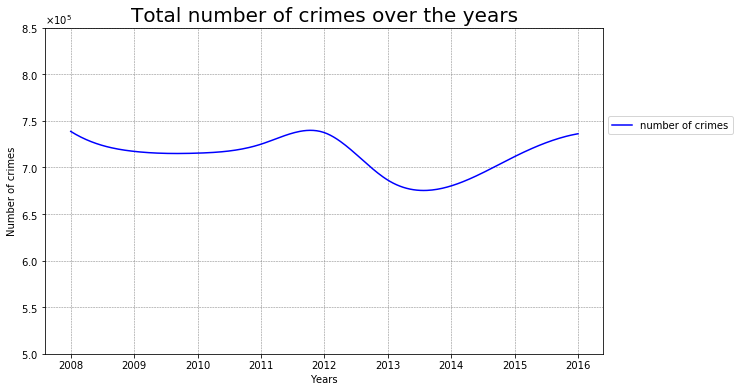

In [127]:
ds = df_nozero.groupby(["year"], as_index=False).aggregate({"value":np.sum})
linee= [{'dataset':ds, 'x_att':"year", 'y_att':"value", 'label':"number of crimes", 'colore':"blue", "linestyle":"-", "marker":" ", "linewidth":1.5}]
ylim =[500000, 850000]
xticks_=ds.year.unique()
xticks_.sort()
draw_linechart(10,6,linee, "Total number of crimes over the years", "Years", "Number of crimes", 0, True, False, 9, True, True, True, xticks_,ylim);

The line graph above shows that the number of crimes is equally distributed between the years with the peaks in 2008, 2012 and 2016; while in 2013 and 2014 there were fewer crimes.
In particular, the maximum number of crimes is in 2008 with a total of 738k crimes, while the lowest value is in 2014 with 680k crimes.

The trend can be defined as costant unless small fluctuations of $\pm 0.1\%$.

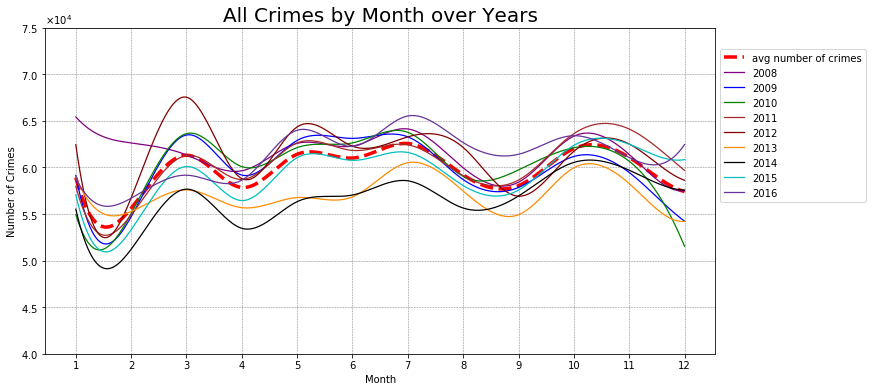

In [128]:
fil = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
ds = df_nozero.groupby(["month","year"], as_index=False).aggregate({"value":np.sum})
col = ["purple","blue","green","brown","maroon","darkorange","black","c","rebeccapurple"]
xticks_=ds['month'].unique()
ylim=[40000, 75000]

AVG=ds.groupby(['month'], as_index=False).aggregate({"value":np.average})
linee= [{'dataset':AVG, 'x_att':"month", 'y_att':"value", 'linewidth': 3.5,'label':"avg number of crimes", 'colore':"red", "linestyle":"--", "marker":""}]
filter_and_plot(ds ,fil,"year","All Crimes by Month over Years", "month", "value","Month","Number of Crimes",col, xticks_, [40000,75000], linee);

In the figure it is possible to compare the monthly trend of each crime in each ``year`` with the average trend.

- The results obtained from the previous figure are confirmed, ie the years ``2013`` and ``2014`` are below the average while ``2008``, ``2012``, ``2016`` are above.

- For every month the total crimes in the years varies at the most by 5k / 10k.

- both the average number of crimes line and the ones referring to the years show some common behavior:
in ``March``, ``May``, ``July`` and ``October`` there are peaks, while the month with less crimes is ``February``.

- in ``March`` there is a critical peak in 2012.

Up to now we know that the number of crimes is almost constant over the years and months less than small fluctuations; the next step is to analyse how the crimes are distributed over the years in terms of major category.

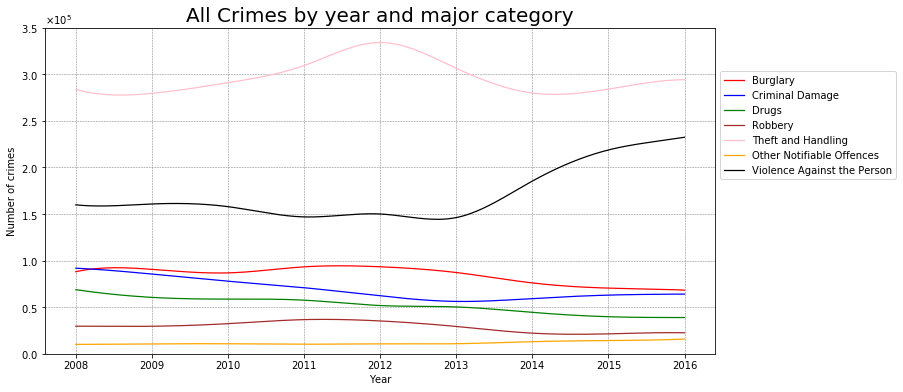

In [129]:
fil = ['Burglary', 'Criminal Damage', 'Drugs', 'Robbery', 'Theft and Handling', 'Other Notifiable Offences', 'Violence Against the Person']
ds = df_nozero.groupby(["major_category","year"], as_index=False).aggregate({"value":np.sum})

col = ["red","blue","green","brown","pink","orange","black","violet","gray"]
ylim=[0, 350000]
xticks_=ds.year.unique()
xticks_.sort()
filter_and_plot(ds,fil,"major_category","All Crimes by year and major category", "year", "value","Year","Number of crimes",col, xticks_, ylim, [])

We decided not to show the lines related to ``Fraud and Forgery`` and `` Sexual Offences`` since the dataset contains only 2008 data for these categories. However we can observe that:

- lines related to different crimes almost never cross each other; this means that the fraction of felony with a specific category over the total number of crimes is costant in time.

- `` Other Notifiable Offences``, `` Robbery``, `` Drugs``, `` Criminal Damage``, `` Burglary`` don't show particular  fluctuations.

- ``Theft and Handling`` has a peak in the year 2012; maybe due to the XXX Olympic Games hosted by the capital.

- `` Violence Against the Person`` felonies are costant up to 2013, then they start to grow, doubling in two years.

We can now visualize the proportions between the major crime's categories without distinguishing by year, since we've already seen that these fractions remain costant during the years.

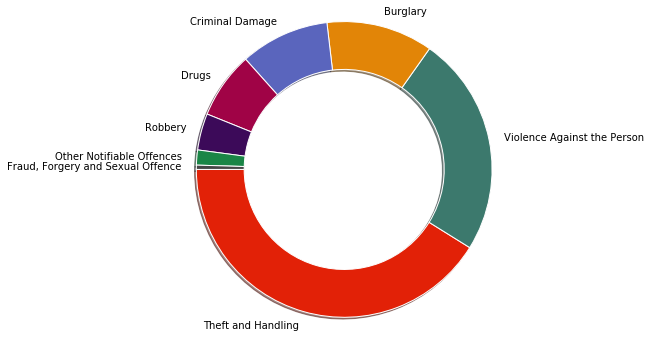

In [11]:
ds= df_nozero.groupby('major_category').aggregate(np.sum)
vals = ds.sort_values(['value'], ascending=[False])[:7]
cols = [(226,33,7), (60,121,109),(226,133,7), (90,101,189), (160,3,70), (60,10,89),(26,133,70), (70,70,70)]
labels = df_nozero.major_category.unique()[:7]
expl = [0, 0, 0, 0, 0, 0, 0, 0]
fontsz = 20
r = 1.7
make_donut(np.append(vals.value.values, 30000), cols, "Major Crime distribution",expl,np.append(vals.index, 'Fraud, Forgery and Sexual Offence'),r, fontsz, save = True)

<a id="donut_table"></a>

Major Category | %
------------ | -------------
Theft and Handling | $41.32$
Violence Against the Person | $24.18$
Burglary | $11.71$
Criminal Damage | $9.79$
Drugs | $7.3$
Robbery | $4.01$
Other Notifiable Offences | $1.65$
Fraud and Forgery & Sexual Offences | $<1$

 - The two most frequent major categories are Theft and Hadling and Violence Against the Person, which respectively  represents the 41% and 24% of the total crimes.

 - Burglary, Criminal Damage and Drugs are the second most frequent crimes with precentages between $[7, 13]$
 
 - The other categories have perctanges $\leq 4$, thus really rare.

For each `` major_category`` we now analyze what are the most influential ``minor_category``.

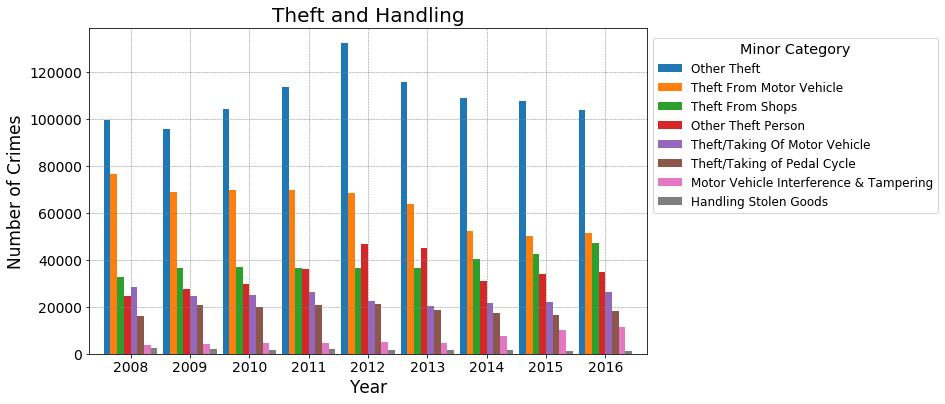

In [131]:
ds=df_nozero[df_nozero['major_category']=='Theft and Handling']
ds=pd.crosstab(ds['year'], ds['minor_category'],values=ds['value'], aggfunc=np.sum)
ds=ds.reindex(ds.mean().sort_values(ascending=False).index, axis=1)
xt = range(2008, 2017)
barChart(ds, "Theft and Handling", "Year", "Number of Crimes", 1, 'Minor Category', xt, 1)

From the barplot above we can observe that, concerning Theft and Handling crimes:

- the most influential `` minor_category`` is `` Other Theft``; it continuously increases with peak in 2012 and subsequent decrement.

- the same is true for `` Theft Person``

- the other minor categories show a costant behavoir

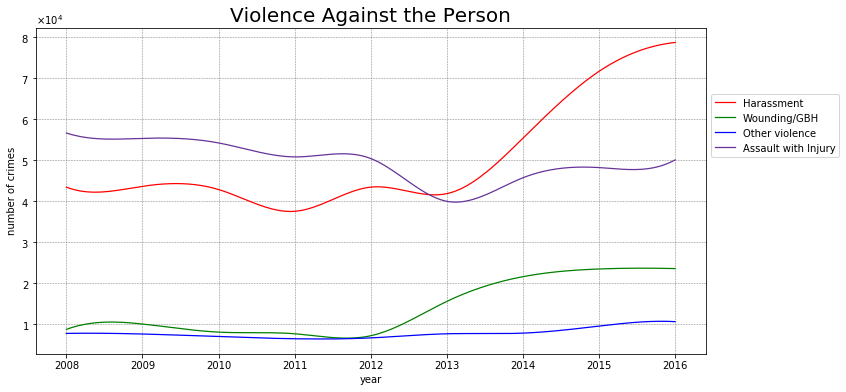

In [132]:
ds = df_nozero.groupby(["major_category","minor_category","year"], as_index=False).aggregate({"value":np.sum})
ds = ds[ds["major_category"]=="Violence Against the Person"]
fil=["Harassment","Wounding/GBH","Other violence", "Assault with Injury"]
col = ["red","green","blue", "rebeccapurple"]
xticks_=ds.year.unique()
filter_and_plot(ds,fil,"minor_category","Violence Against the Person", "year", "value", "year","number of crimes",col, xticks_, [], [])

Reading several newspapers articles ([BBC](https://www.bbc.com/news/uk-england-london-45189359), [The Guardian](https://www.theguardian.com/uk-news/2018/apr/27/why-are-knife-and-gun-offences-on-the-rise-and-who-is-most-at-risk))we found out that violence related crimes are increasing in London. The line plot above confirms this fact:

- ``Violence Against the Person`` increases from 2014.

- `` Harrassment`` and `` Wounding / GBH`` determine the general trend of their `` major_category``. It can also observed that both felonies doubled their values in 2016 compared to 2013.

- The second `` minor_category`` with higher values is `` Assault with Injury`` which suffers from a descent until 2013 and then increases again.

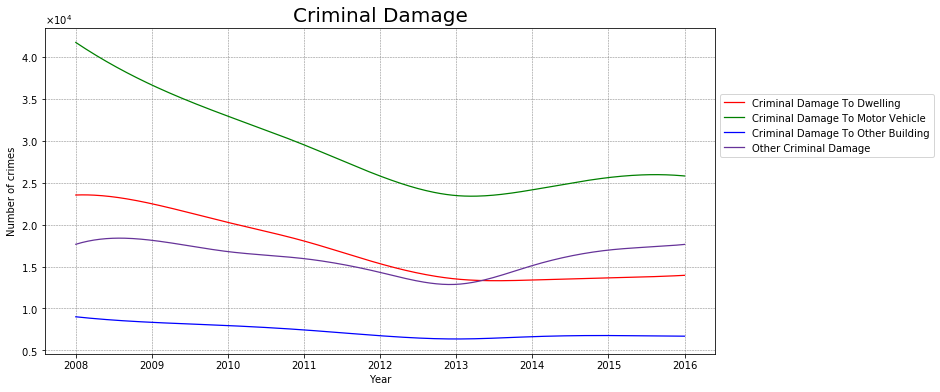

In [133]:
ds = df_nozero.groupby(["major_category","minor_category","year"], as_index=False).aggregate({"value":np.sum})
ds = ds[ds["major_category"]=="Criminal Damage"]
fil=ds.minor_category.unique()
col = ["red","green","blue", "rebeccapurple"]
xticks_=ds.year.unique()
filter_and_plot(ds,fil,"minor_category","Criminal Damage", "year", "value", "Year","Number of crimes",col, xticks_, [], [])

The dominant `` minor_category`` for `` Criminal Damage`` is `` Criminal Damage to Motor Vehicle`` whose total number of crimes decreases over the years, as well as `` Criminal Damage To Dwelling`` and ``Criminal Damage To Other Building`` felonies.

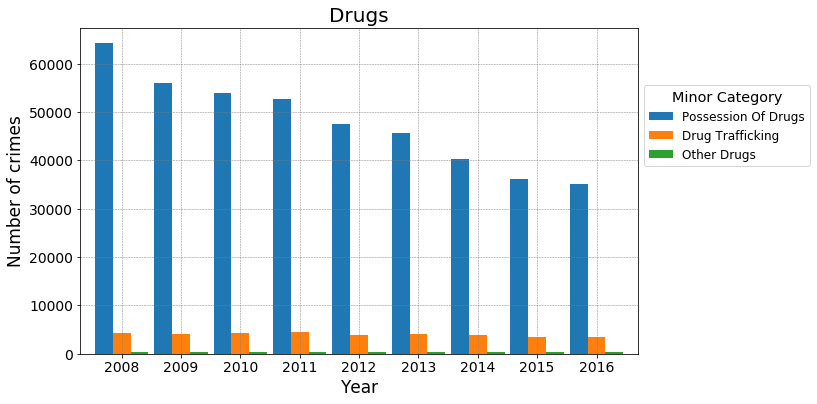

In [134]:
ds=df_nozero[df_nozero['major_category']=='Drugs']
ds=pd.crosstab(ds['year'], ds['minor_category'],values=ds['value'], aggfunc=np.sum)
ds=ds.reindex(ds.mean().sort_values(ascending=False).index, axis=1)
barChart(ds, "Drugs", "Year", "Number of crimes", 1, 'Minor Category', xt, 1)

There are three `` minor_category`` for `` Drugs`` and from the barplot above emerges that:
- ``Possession of Drugs`` crimes are much greater than `` Drug Trafficking`` and `` Other Drugs``. 

- `` Possession of Drugs`` follows, as the general ``Drugs`` felonies distribution, a decreasing trend.

- ``Drug Trafficking`` and `` Other Drugs`` distributions appear to be costant. 

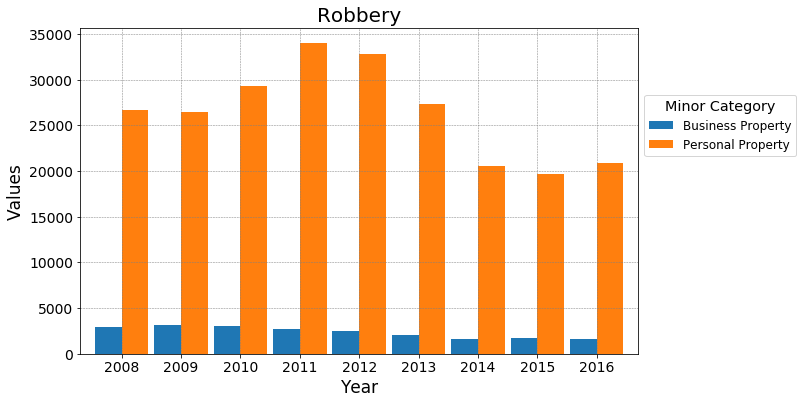

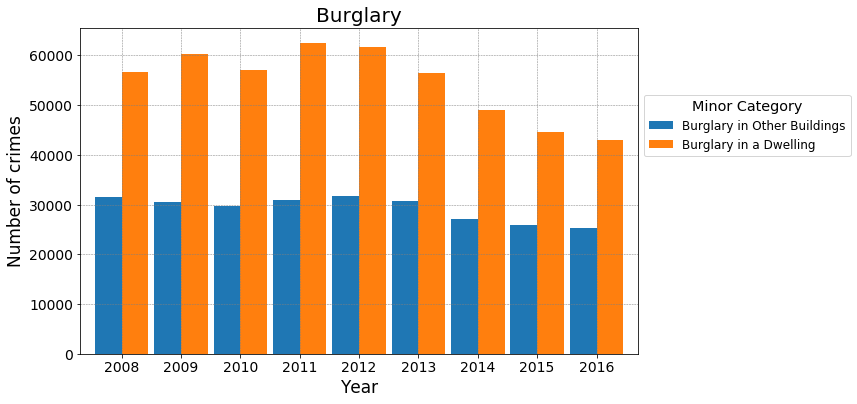

In [135]:
#Robbery
ds=df_nozero[df_nozero['major_category']=='Robbery']
ds=pd.crosstab(ds['year'], ds['minor_category'],values=ds['value'], aggfunc=np.sum)
dsf=ds.reindex(ds.mean().sort_values(ascending=False).index, axis=1)
barChart(ds, "Robbery", "Year", "Values", 1, 'Minor Category', xt, 1)

#Burglary
ds=df_nozero[df_nozero['major_category']=='Burglary']
ds=pd.crosstab(ds['year'], ds['minor_category'],values=ds['value'], aggfunc=np.sum)
dsf=ds.reindex(ds.mean().sort_values(ascending=False).index, axis=1)
barChart(ds, "Burglary", "Year", "Number of crimes", 1, 'Minor Category', xt, 1)

`` Robbery`` and `` Burglary`` have the same trend (growth of crimes with peak in `` year`` ``2011`` and ``2012``) but ``Burglary`` crimes are twice the number of ``Robbery`` ones.

<a id='geo'></a>
### 3.B Geolocalized Features Distribution ([to top](#top))
We already looked at data from a statistical perspective, but since we're dealing with geographic entities such as LSOAs and boroughs a further geolocalized crime inspection is needed.
In order to do so we enriched the filtered dataset with geographical attributes and enginnered new features.

The first step is to merge the base dataset with a lookup table that associates each LSOA with its latitude e longitude.

In [136]:
df_geo = get_geo_ds(df_nozero)
explore_ds(df_geo)

|Dataset| = 3419099
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3419099 entries, 0 to 3419098
Data columns (total 9 columns):
lsoa_code         object
borough           object
major_category    object
minor_category    object
value             int64
year              int64
month             int64
lat               float64
long              float64
dtypes: float64(2), int64(3), object(4)
memory usage: 260.9+ MB
--------------
lsoa_code has 4835 different values
borough has 33 different values
major_category has 9 different values
minor_category has 32 different values
value has 246 different values
year has 9 different values
month has 12 different values
lat has 4835 different values
long has 4835 different values


Then we load both boroughs and LSOAs shape datasets consisting of geometrical information such as polygons representing the LSOA/borough in the cartographic space.
This two dataset are the core of the geolocalized analysis since, combined with the [GeoPandas library](http://geopandas.org/), allow us to show quantitative values over geographical data. 

In [137]:
df_borough = geopandas.read_file('data/geo/London_Borough_Excluding_MHW.shp').rename(columns = {'NAME': 'borough'})
df_lsoa = geopandas.read_file('data/geo/LSOA_2011_London_gen_MHW.shp').rename(columns = {'LSOA11CD': 'lsoa_code'})

Before plotting we need another data preparation step. It's true that we're handling geographical data, but even in this perspective we can't ignore the temporal context. So, in order to proceed with a time-series-like approach, we split the geo dataset by year.

In [138]:
df_year = get_lsoasplit_by_year(df_geo, no_crime=True)
df_year[0].head(5)

,lsoa_code,lat,borough,long,value,geometry,crime/month
0,E01000006,51.539015,Barking and Dagenham,0.087994,105,"POLYGON ((545122.048999952 184314.931000118, 5...",8.750000
1,E01000007,51.540601,Barking and Dagenham,0.077959,344,"POLYGON ((544180.3469999625 184700.582000125, ...",28.666667
2,E01000008,51.540013,Barking and Dagenham,0.070140,208,(POLYGON ((543741.0009997987 184565.9999999668...,17.333333
3,E01000009,51.540542,Barking and Dagenham,0.083350,321,"POLYGON ((544499.8369998914 184704.366, 544630...",26.750000
4,E01000010,51.537332,Barking and Dagenham,0.078942,1091,"POLYGON ((544173.9999997641 184360.9999999579,...",90.916667


At this point we have 9 datasets, one for each year between $2008$ and $2016$, sharing the same schema and semantics.

To reason about the number of crimes in a more *human-friendly* way we also engeneered a quantitative attribute,``crime/month``, equals to $\frac{value}{12}$.

Since here the purpose is to better understand the trends highlighted in the [exploratory analysis section](#ea), we choose to reproduce the same plots in this geolocalized analysis. The quantitative information  that we choose to represent is the``crime/month`` attribute.
We modeled and visualized this dimension at LSOA-level with the help of a colormap, while we still show boroughs edges.

The main problem in this phase was finding the right color map settings, that are its steps. For each plot we analyzed both percentiles values and histograms to extract a binning, and coloring, that allows to distinguish and identify LSOAs with an high crime rate. 

For example if we want to choose a good binning for plotting the total number of crimes we first look at percentile information:

In [10]:
df_year[4]['crime/month'].describe()

count    4835.000000
mean       12.708187
std        19.017388
min         0.250000
25%         6.333333
50%         9.000000
75%        13.250000
max       551.416667
Name: crime/month, dtype: float64

Given the output of the code above we can notice that the 75% of LSOAs has a ``crime/month`` value in $[0, 13.25]$ so, in order to avoid an almost-monochromatic plot, we won't assign to these values a dark color, namely an high position in the color map range.
This method combined with tuning by histograms led to the binnings used from now on.

In each choropleth map we also show:

- in *black* the names of the borough with at least one LSOA that falls in the two highest ranges of the colormap.
We will call such LSOA an **hotspot**;

- in *gray* the names of the broughs with at least one LSOA that falls in the third highest ranges of the colormap;
We will call such LSOA a **concerning** one;

This additional information will also provide us an implicit borough claffisication, indeed we can now compute a **colormap-induced-score $s$**  and rank boroughs in each plot. For each borough $b$, the score is computed as:

$$s(b)=n_b + \frac{n_g}{2}, \; \; \; n_b, n_g\in[0,9]$$

where $n_b$ and $n_g$ are resplectively the number of times $b$ appears in black and gray in the map. To assign a lower weight to gray-appearance-events we divided $n_g$ by $2$. Finally with appropriate thresholds on $s$,  $t_{danger}$ and $t_{not-danger}$, we can now distinguish between:

- **dangerous** boroughs, all boroughs $b_i$ such that $s(b_i)\geq t_{danger}$

- **almost-dangerous** boroughs, all boroughs $b_i$ such that $ t_{not-danger} < s(b_i) < t_{danger}$

#### All crimes

Let's start by showing how the overall ``crime/month`` rate varies over the years and the [table](#all_Crime_table) of all the dangerous boroughs extracted.

In [ ]:
crime = "all"
print_chorophlet_years(df_year, 'crime/month', crime, bounds[crime], 'lsoa', False,'jpg', (20, 12)) 

![All Crimes in London](gif/all_crimes.gif)
<hr>

<a id="all_Crime_table"></a>

Borough | s
------------ | -------------
Westminster | 9.0
Kingston upon Thames | 8.5
Hillingdon | 6.0
Croydon | 4.5
Newham | 4.5
Camden | 4.5

The animated map above confirms that the total number of crimes is almost equally distibuted over the years but, with the help of the table, we can further observe that:

1. dangerous and almost-dangerous boroughs are pretty much the same over the years

2. the first three dangerous boroughs, resulting from the table, have a score really close to the maximum. This means that they have been the most dangerous ones almost every year  

3. hotspots inside dangerous boroughs are usually isolated, indeed in a dangerous borough there is at most one critical LSOA, and this LSOA often confines only with not-critical ones; an exception is Westminister where all the LSOAs nearby the Thames always have a dark color

4. Westminister and, in general the LSOAs above the Thames tend to be the most dangeorus zones 

5. Kingston upon Thames is the best example of borough described by point 3 of this list: its score is given only by one highly dangerous and isolated LSOA.

6. The central white LSOA corresponds to the City of London area and there are no crimes associated with this zone.

Let's now focus our analysis on the most frequent major crime categories: *Theft and Handling*, *Violence Against the Person*, *Criminal Damage*, *Burglary* and *Robbery*.
For each crime $c_i$ we will plot a choropleth map and compute the related score $s_{c_i}$, from which we extracted the most dangerous boroughs table.  

#### Theft and Handling


![Theft and Handling](gif/tah.gif)
<hr>

Borough | $s_{TheftHandling}$
------------ | -------------
Westminster | 9.0
Kingston upon Thames | 9.0
Hillingdon | 9.0
Hammersmith and Fulham | 8.0
Camden | 8.0
Newham | 7.0
Islington | 6.5
Haringey | 5.0
Hackney | 5.0
Ealing | 4.5

- the most dangerous boroughs are the same as before

- scores are higher, meaning that this category of crimes shows a more stable behavoir with the respect of our score, in the sense that hotspots are likely to remain the same.

- focusing only on the map, this category of crime it's spatially and quantitatively distributed similarly to the total number of cime/month; this follows also from the fact that theft and handling crimes represent the major fraction

- the same observation about hotspots isolation are still valid

#### Violence Against the Person


![Violence Against the Person](gif/vatp.gif)
<hr>

Borough | $s_{Violence}$
------------ | -------------
Westminster | 9.0
Kingston upon Thames | 9.0
Croydon | 9.0
Havering | 8.5
Camden | 7.5
Lambeth | 6.0
Hillingdon | 6.0
Sutton | 5.5
Hammersmith and Fulham | 4.5
Ealing | 4.5 

- the general increase of violence it's even more critical in the map: the number of crime/month it's stable up to 2013, from that point on it starts to grow as the number of hotspots - and dangerous boroughs - 
grows too.

- crimes are denser and higher in number in the northern bank of the Thames also in this case

- if we look at the table, boroughs with score in $[7.5, 9]$ are the almost-always dangerous one; while a score in $[4.5, 6]$ correspond to boroughs where the violence has increased recently

- hotspots still behave in the same way as before

#### Burglary & Robbery

Since for burglary and robbery crimes no significant phenomenon has been observed from the geographical representation, we just show the related tables. 

Borough | $s_{Burglary}$ | Borough | $s_{Robbery}$ 
------------ | ------------- | ------------ | -------------
Westminster | 9.0 | Westminster | 9.0
Camden | 6.5 | Lambeth | 3.5
Islington | 5.5 | Newham | 3.5
Croydon | 4.0 | Croydon | 3.0
Hackney | 4.0 |  | 

This tables enrich our knowledge because if in the [feature distribution analysis](fd) we could only say that both robbery and burglary crimes follow almost the same trend, with bruglary felonies greater in number, now we can also say that the two categories are spatially distributed in different ways; except from the Westminister borough that up to now has always been the most dangerous one. 

#### Drugs

![Drug Crimes](gif/drugs.gif)
<hr>

Borough | $s_{Drugs}$
------------ | -------------
Westminster | 7.5
Camden | 6.5
Tower Hamlets | 3.0
Southwark | 2.5
Kingston upon Thames | 1.0

- we can confirm that drug crimes are critically decreasing 

- hotspots have become concerning LSOA 

- where in the past there was a concerning LSOA, year after year we can observe a spreaded tendency to felonies zeroing 

#### Criminal Damage

Criminal Damage map was not so significant, so we only show the extracted table.

Borough | $s_{CriminalDamage}$
------------ | -------------
Westminster | 9.0
Kingston upon Thames | 9.0
Croydon | 7.0
Sutton | 4.5
Ealing | 4.5

Once we have collected all the scores, for each borough we can now define a **weigthed score**: 

$$\forall b \in \lbrace Boroughs\rbrace , ws(b) = \sum_{ c \in MC }{s_{c}(b)\times w_c}$$

where $ws(b)\in [0, 9]$, $MC$ is the set of major categories of crime considered, $s_{c}(b)$ is the score of the borough $b$ in the category $c$ and $w_c$ is the weight assigned to the crime $c$. The weights are the percentage of crimes with major category equals to c over the total crime number. So, looking at the donut chart in the first section we'll have that theft and handling crimes weight $\approx 0.4$, Violence crimes $\approx 0.25$ and so on.

This score represent a first, naive, *danger indicator*: a score close to 9 means that inside that borough, since 2008, there was at least one hotspot for each crime category. The table below shows a normalized version of $ws$.
<a id="rank_table"></a>

Borough | $ws$ 
------------ | -------------
Westminster | 0.98  
Kingston upon Thames | 0.77 
Camden | 0.75 
Hillingdon | 0.63 
Croydon | 0.56 
Hammersmith and Fulham | 0.53 
Newham | 0.52 

Looking at the boroughs names we have:

- 3 boroughs that are in the city centre and on the northern bank of the Thams: Westminster, Camden, Hammersmith and Fulham; this confirms the hypotized dangerousness the involved zones

- Hillingdon, even if appears with an high score, shows almost always only one hotspot, that concides with the LSOA that cointains the airport

- all the other boroughs in the list are like Hillingdon, and this high crime density in just few LSOA is certainly a phenomenon that deserves further analysis.

<a id='cc'></a>
### 3.C Correlations ([to top](#top))

Also in the correlation analysis we choose to study the problem with a time-series-like approach by means of the previously splitted datasets.
The main problem in this phase was the lack of numerical quantitative attributes in the original dataset; indeed we only have ``value``. The first thing to do is to reshape the datasets in order to have more independet variables.

<a id='dr'></a>
#### 3.C.a Dataset Reshaping ([to top](#top))

The first idea was to create one numerical attribute for each major category that contains the sum of the values of that kind of crime in the current year - since we're dealing with a dataset split by year - for a specific LSOA.
Thus these new datasets will contain 4835 rows, namely the number of LSOA, and 9 new attributes, one for each major category.

In [40]:
df = df_nozero
df_year_reshaped = [df[df['year'] == i ].groupby(['lsoa_code', 'major_category'], as_index=False).agg({
    'value':np.sum,
    'borough':'first'
}) for i in range(2008, 2017)]
for i in range(0, len(df_year_reshaped)):
    df_year_reshaped[i] = reshape_crimes(df_year_reshaped[i]);
df_year_reshaped[0].head()

1000 lsoa computed
2000 lsoa computed
3000 lsoa computed
4000 lsoa computed
1000 lsoa computed
2000 lsoa computed
3000 lsoa computed
4000 lsoa computed
1000 lsoa computed
2000 lsoa computed
3000 lsoa computed
4000 lsoa computed
1000 lsoa computed
2000 lsoa computed
3000 lsoa computed
4000 lsoa computed
1000 lsoa computed
2000 lsoa computed
3000 lsoa computed
4000 lsoa computed
1000 lsoa computed
2000 lsoa computed
3000 lsoa computed
4000 lsoa computed
1000 lsoa computed
2000 lsoa computed
3000 lsoa computed
4000 lsoa computed
1000 lsoa computed
2000 lsoa computed
3000 lsoa computed
4000 lsoa computed
1000 lsoa computed
2000 lsoa computed
3000 lsoa computed
4000 lsoa computed


,lsoa_code,borough,value,Burglary_value,Criminal Damage_value,Drugs_value,Robbery_value,Sexual Offences_value,Theft and Handling_value,Violence Against the Person_value,Fraud or Forgery_value,Other Notifiable Offences_value
0,E01000006,Barking and Dagenham,105,12,7,8,6,1,37,34,0,0
1,E01000007,Barking and Dagenham,344,12,17,70,18,1,102,117,1,6
2,E01000008,Barking and Dagenham,208,8,29,15,12,1,74,41,24,5
3,E01000009,Barking and Dagenham,321,18,33,65,32,1,70,93,2,7
4,E01000010,Barking and Dagenham,1091,29,99,99,41,1,529,258,13,22


Now we add demographic and economic indicators.

In [142]:
for i in range(0, len(df_year_reshaped)):
    #d.drop(['year', 'month'], axis = 1, inplace=True)
    df_year_reshaped[i] = get_corr_ds(df_year_reshaped[i])
df_year_reshaped[0].columns

Index([u'lsoa_code', u'borough', u'value', u'Burglary_value',
       u'Criminal Damage_value', u'Drugs_value', u'Robbery_value',
       u'Sexual Offences_value', u'Theft and Handling_value',
       u'Violence Against the Person_value',
       ...
       u'No religion', u'Religion not stated', u'area (hectars)', u'density',
       u'mean price', u'Very good or Good health', u'Fair health',
       u'Bad or Very Bad health', u'Sum of cars-vans',
       u'Total Number of Children'],
      dtype='object', length=137)

and points of interest such as monuments, bus stations...

In [143]:
#POIs + cleaning **********************
df_poi = pd.read_csv('data/corr/london-points-of-interest.csv').rename(columns = {'lng': 'long'}).drop([
    'category', 'id', 'address', 'originalId', 'polarity', 'details', 'reviews'
], axis = 1)
df_poi = df_poi[df_poi['long'] != 'London']
df_poi['lat'] = df_poi['lat'].apply(float)
df_poi['long'] = df_poi['long'].apply(float)
df_poi.sort_values(["long","lat"])
df_poi.head(1)

,lat,long,location,name,subCategory
0,51.49529,-0.166223,London,The Enterprise,Pub


In [144]:
#optimization step
dg_gb = df_nozero.groupby("lsoa_code",as_index=False).agg({"borough":"first"})

#load lookup table postal_code -> lsoa_code
lc_lookup = pd.read_csv("data/london-lookup1.csv").rename(columns = {'lsoa11': 'lsoa_code'})
lc_lookup["pcd"] = lc_lookup.apply(lambda row: row["pcd"].replace(" ",""), axis=1)

at = ["Bus Station"]
gb_attr = ["lsoa_code","borough"]

to_drop = ["lat","location","name","subCategory","postal_code"]


#insert_pois(at, gb_attr, df_poi, to_drop, df_years_reshaped )

#instead of computing the reverse geocoding we load the precomputed dataset
reshaped_years = []
for i in range(0, 9):
    df = pd.read_csv("data/reshapedNew"+str(i)+".csv")
    reshaped_years.append(df.drop(['year', 'area.1'], axis =1))
print("|rows|: "+str(len(reshaped_years[5]))+"\n|colums|: "+str(len(reshaped_years[5].columns)))

|rows|: 4835
|colums|: 50


We are now ready to compute some correlation. We will analyse the correlation between values of crimes and:

- themselves
- demographic indicators
- points of interest

we also tried to include economic indicators in the correlation analysis but they didn't show statistically significant results.

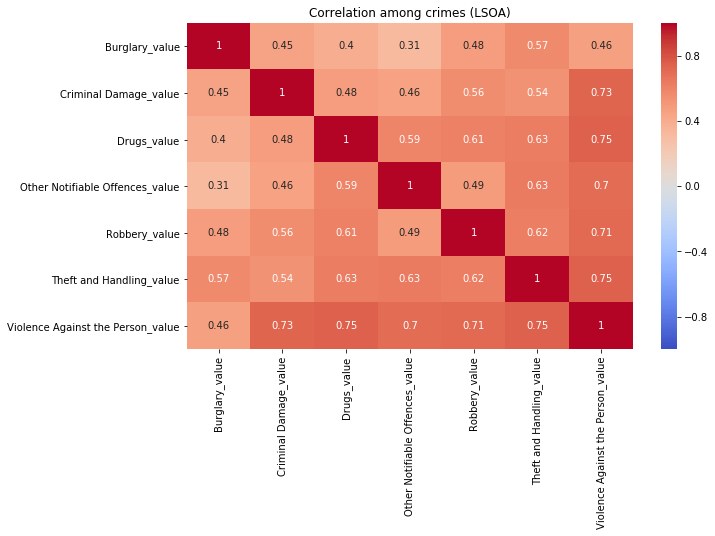

In [67]:
to_keep_value = ['Burglary_value', 'Criminal Damage_value','Drugs_value',\
                 'Robbery_value', 'Theft and Handling_value','Violence Against the Person_value',\
                 'Other Notifiable Offences_value']
to_keep = to_keep_value

col = reshaped_years[0].columns


for k in to_keep:
     col = col.delete(get_ind(col,k))
        
        
ds_heat=[]        
    
d=reshaped_years[0].drop(col,axis=1)
d.sort_index(axis=1,inplace=True)
ds_heat.append(d)

heatmap_years(ds_heat, True, True, title="Correlation among crimes (LSOA)", size = (10, 6))

Since the mutual correlations between differnt categories of crimes are strong both at LSOA and borough level we can say that if a borough has an high number of crimes, and thus can be considered dangerous with our score, it's likely to have an high number of crimes in all categories; this observation its related to the score defined in the pevious section because the crime levels seem to be higher in some recurring zones as the northern bank of the Thames and the city center in general, resulting in very high scores in the [final rank table](#rank_table).

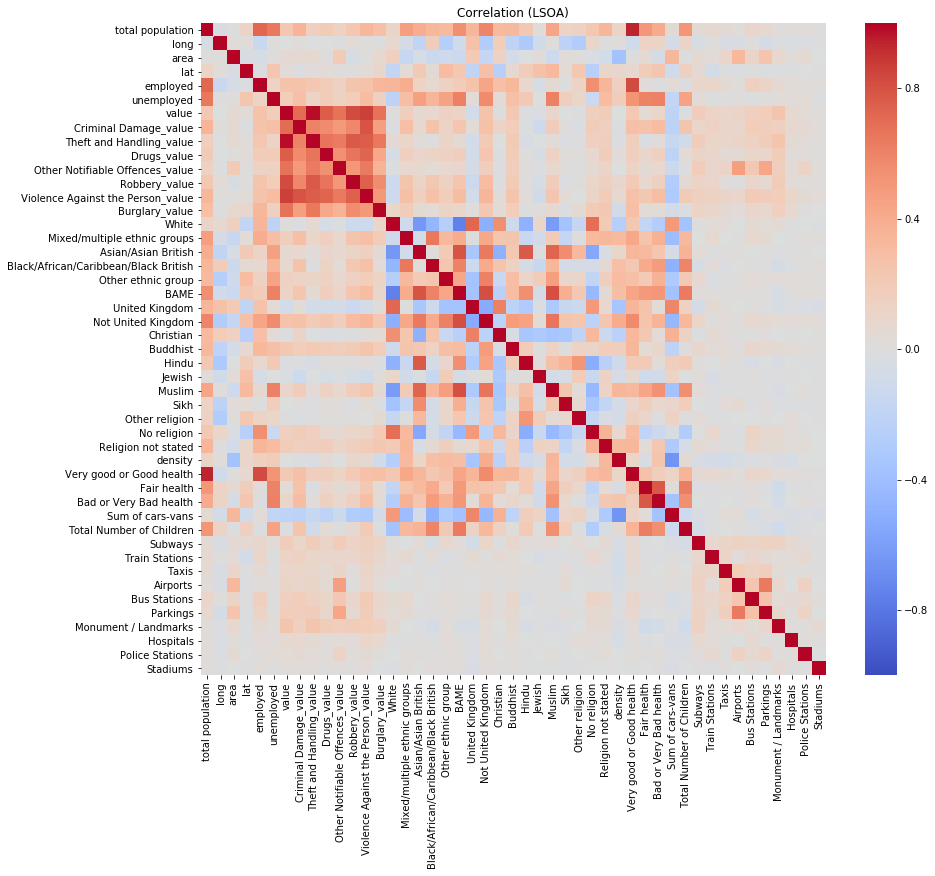

In [145]:
v = reshaped_years[5]
heatmap_years([v], False, False, title="Correlation (LSOA)")

From the correlation matrix above emerges that the only strongly correlated subset of attributes is the one of crime values. All the new features seemed not correlated with the values of the crimes, the only notable correlation is between the number of Airports in an LSOA and Other Notifiable Offences_value. 

We now try to see the same correlations at borough level.

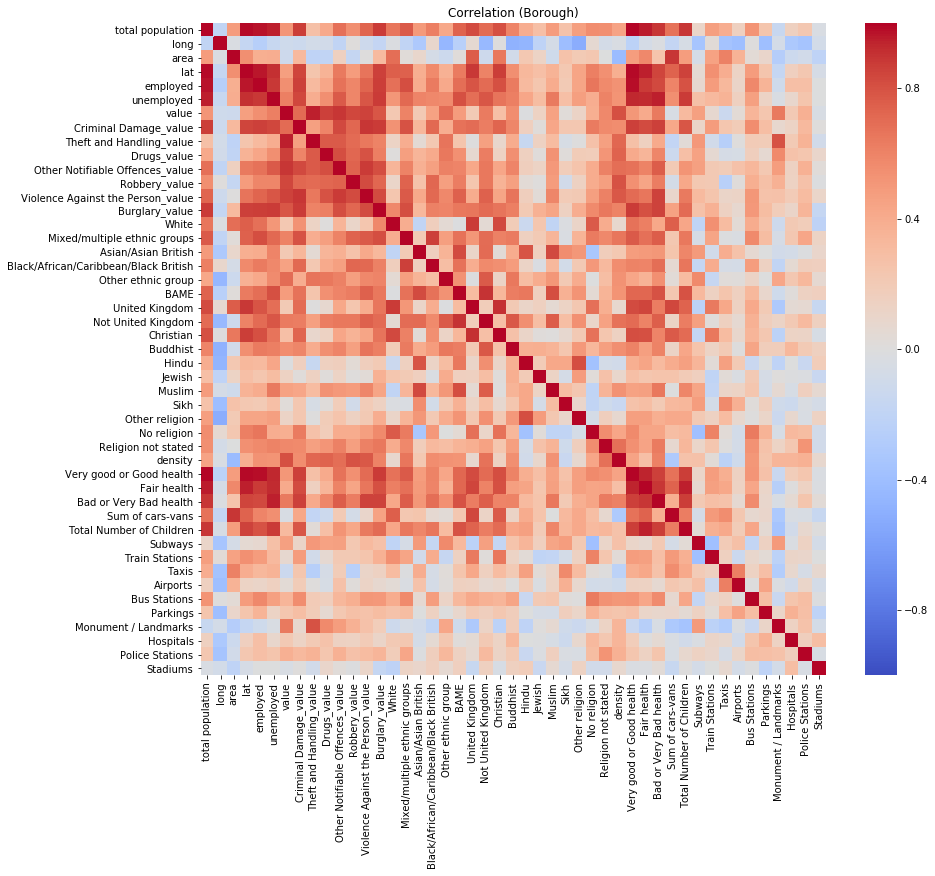

In [146]:
ds_gb = []

for i in range(0,len(reshaped_years)):
    d = reshaped_years[i].groupby(["borough"],as_index=False).sum()
    ds_gb.append(d)
v = ds_gb[5]
heatmap_years([v], False, False, title="Correlation (Borough)")

This time we can spot different interesting correlations, but in order to have a more understandable visualization we will focus on the correlation between values of crime and the different classes of attributes introduced separately.

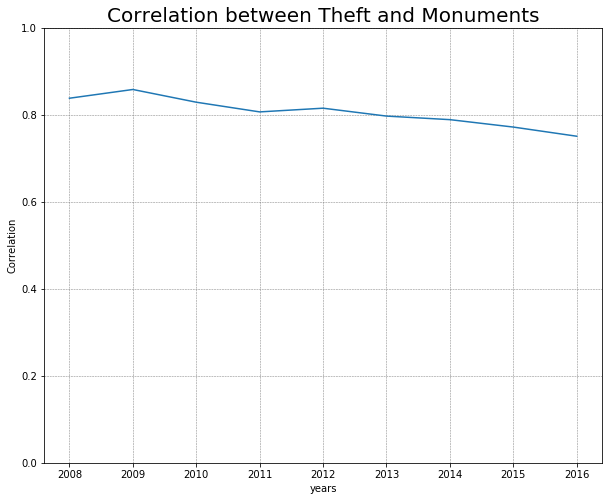

In [110]:
plot_corr_by_year(ds_gb, "Theft and Handling_value", "Monument / Landmarks", "Correlation between Theft and Monuments", save = False)

In [ ]:
y="Monument / Landmarks" 
x = "Theft and Handling_value"

scatter_plot_corr(ds_gb, x, y, True)

![Theft and Monuments](gif/theft_monuments.gif)

This strong correlation confirms our first impression: the theft crime is “focused” in the center of London, the (Touristic) Center can be individuated by the position of the Monuments, and assuming that a Borough is as Central as the number of monuments that falls in that Borough we can conclude that places near monuments have an high risk of theft and handling crimes (for example beacause they are crowded by thousand of tourists).
We also noticed that this correlations is decresing linearly during years.


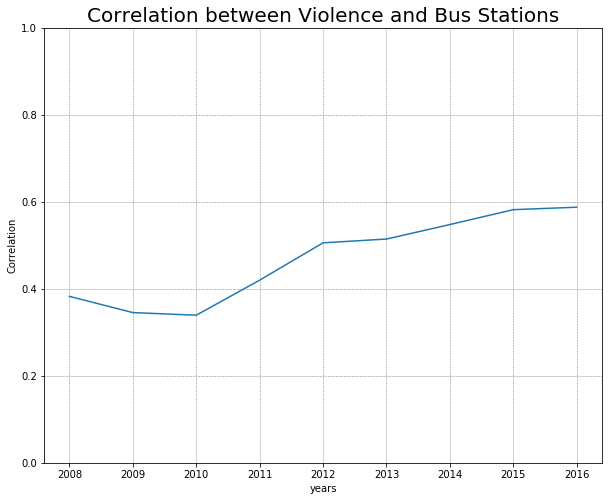

In [117]:
y="Bus Stations" 
x = "Violence Against the Person_value"

plot_corr_by_year(ds_gb, x, y, "Correlation between Violence and Bus Stations", save = True)

In [ ]:
scatter_plot_corr(ds_gb, x, y, True)

![Violence and Bus Stations](gif/violence_bus.gif)

This correlation can be interpreted in two ways:

1. violence is increasing near bus stations

2. since violence is genarally increasing in the last years, it's more likely that such a felony will occur in the proximity of a bus station, that are many and really dense in some zones.

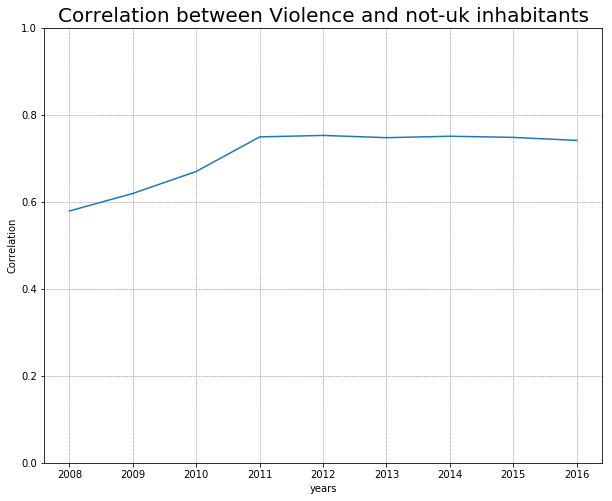

In [148]:
y="Not United Kingdom" 
x = "Violence Against the Person_value"

plot_corr_by_year(ds_gb, x, y, "Correlation between Violence and not-uk inhabitants", save = False)

In [ ]:
scatter_plot_corr(ds_gb, x, y, True)

![violence no uk](gif/violence_nouk.gif)

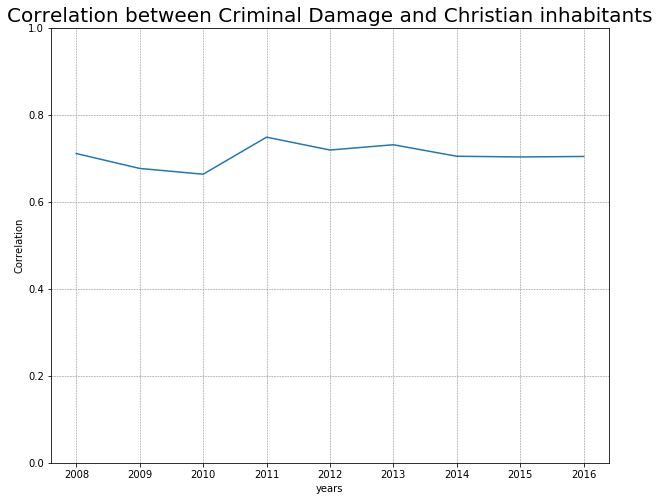

In [121]:
y="Christian" 
x = "Criminal Damage_value"

plot_corr_by_year(ds_gb, x, y, "Correlation between Criminal Damage and Christian inhabitants", save = True)

In [ ]:
scatter_plot_corr(ds_gb, x, y, True)

![crimanl crist](gif/criminal_crist.gif)

These last plots suggest that the number of criminal damage crimes in a borough is correlated with the number of Christians. This gives us the opportunity to highlight that even if a crime is happend in a place it doen't mean that their population is the active part, but can also be the victim. So in this case we can't know if the Christian population palys an active or passive role in this crime category.